In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

In [3]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os
from degree_days import dds



def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values

In [6]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [8]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse
from common import compute_rmse_fraction


In [9]:
import pickle

def load_obj(name):
    with open(os.path.expanduser('~/git/' + name + '.pkl'), 'rb') as f:
        return pickle.load(f)

In [13]:
pred = {}
for method in ['normal', 'transfer']:
    pred[method] = {}
    for algo in ['adagrad', 'gd']:
        pred[method][algo] = {}
        for static_fac in ['static', 'None']:
            pred[method][algo][static_fac] = {}
            for random_seed in range(10):
                pred[method][algo][static_fac][random_seed] = load_obj("pred_static/pred_{}_{}_{}_{}".format(method, algo, static_fac, random_seed))

In [15]:
out = {}

for method in ['normal', 'transfer']:
    out[method] = {}
    for algo in ['adagrad', 'gd']:
        out[method][algo] = {}
        for static_fac  in ['static', 'None']:
            out[method][algo][static_fac] = {}
            for random_seed in range(10):
                out[method][algo][static_fac][random_seed] = {}   
                for appliance in APPLIANCES_ORDER[1:]:
                    out[method][algo][static_fac][random_seed][appliance] = {}
                    for f in range(10,110,10):
                        s = pd.concat(pred[method][algo][static_fac][random_seed][appliance][f]).ix[sd_df.index]
                        if appliance=="hvac":
                            out[method][algo][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
                        else:   
                            out[method][algo][static_fac][random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]


/Users/xox/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [16]:
mean_out = {}
for method in ['normal', 'transfer']:
    mean_out[method] = {}
    for algo in ['adagrad', 'gd']:
        mean_out[method][algo] = {}
        for static_fac  in ['static', 'None']:
            mean_out[method][algo][static_fac] = pd.Panel(out[method][algo][static_fac]).mean(axis=0)

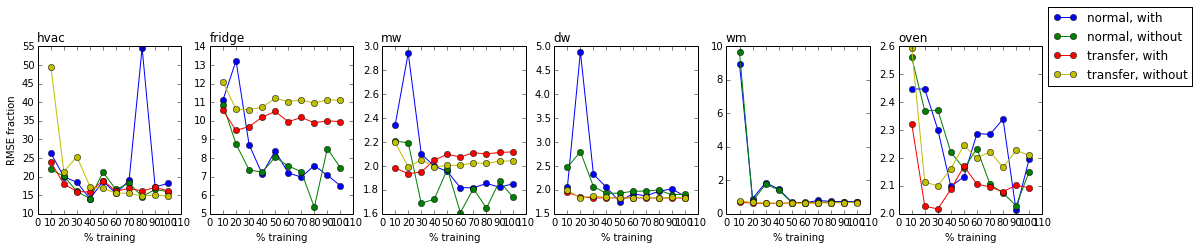

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 80))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
    df1 = mean_out['normal']['gd']['static'][appliance]
    df2 = mean_out['normal']['gd']['None'][appliance]
    df3 = mean_out['transfer']['gd']['static'][appliance]
    df4 = mean_out['transfer']['gd']['None'][appliance]
    df = pd.concat([df1, df2, df3, df4], axis = 1)
    pd.DataFrame(df).plot(ax=ax[count],figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g','r', 'y', 'k', 'c'])
    ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))


#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% training");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_title(appliance, loc="left")
    ax[count].legend().set_visible(False)
    count += 1
ax[0].set_ylabel('RMSE fraction')

ax[count-1].legend(["normal, with", 'normal, without', 'transfer, with', 'transfer, without'], loc='center left' , bbox_to_anchor=(1, 1))
# plt.savefig("./analysis/0720/with_without_static_.pdf", bbox_inches="tight", dpi=300, format='pdf')